<center><h1>1-e: Transformers</h1></center>


DONE BY:
- AZIZI Walid
- KEBIR Ahmed Rayane

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

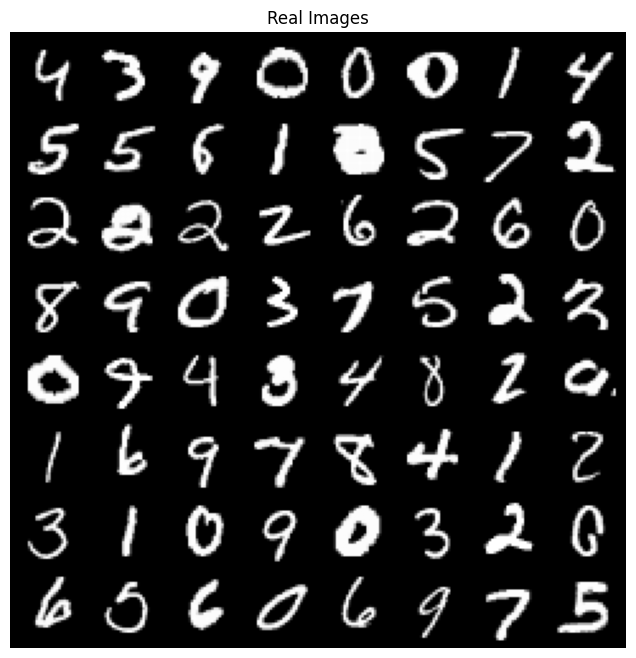

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

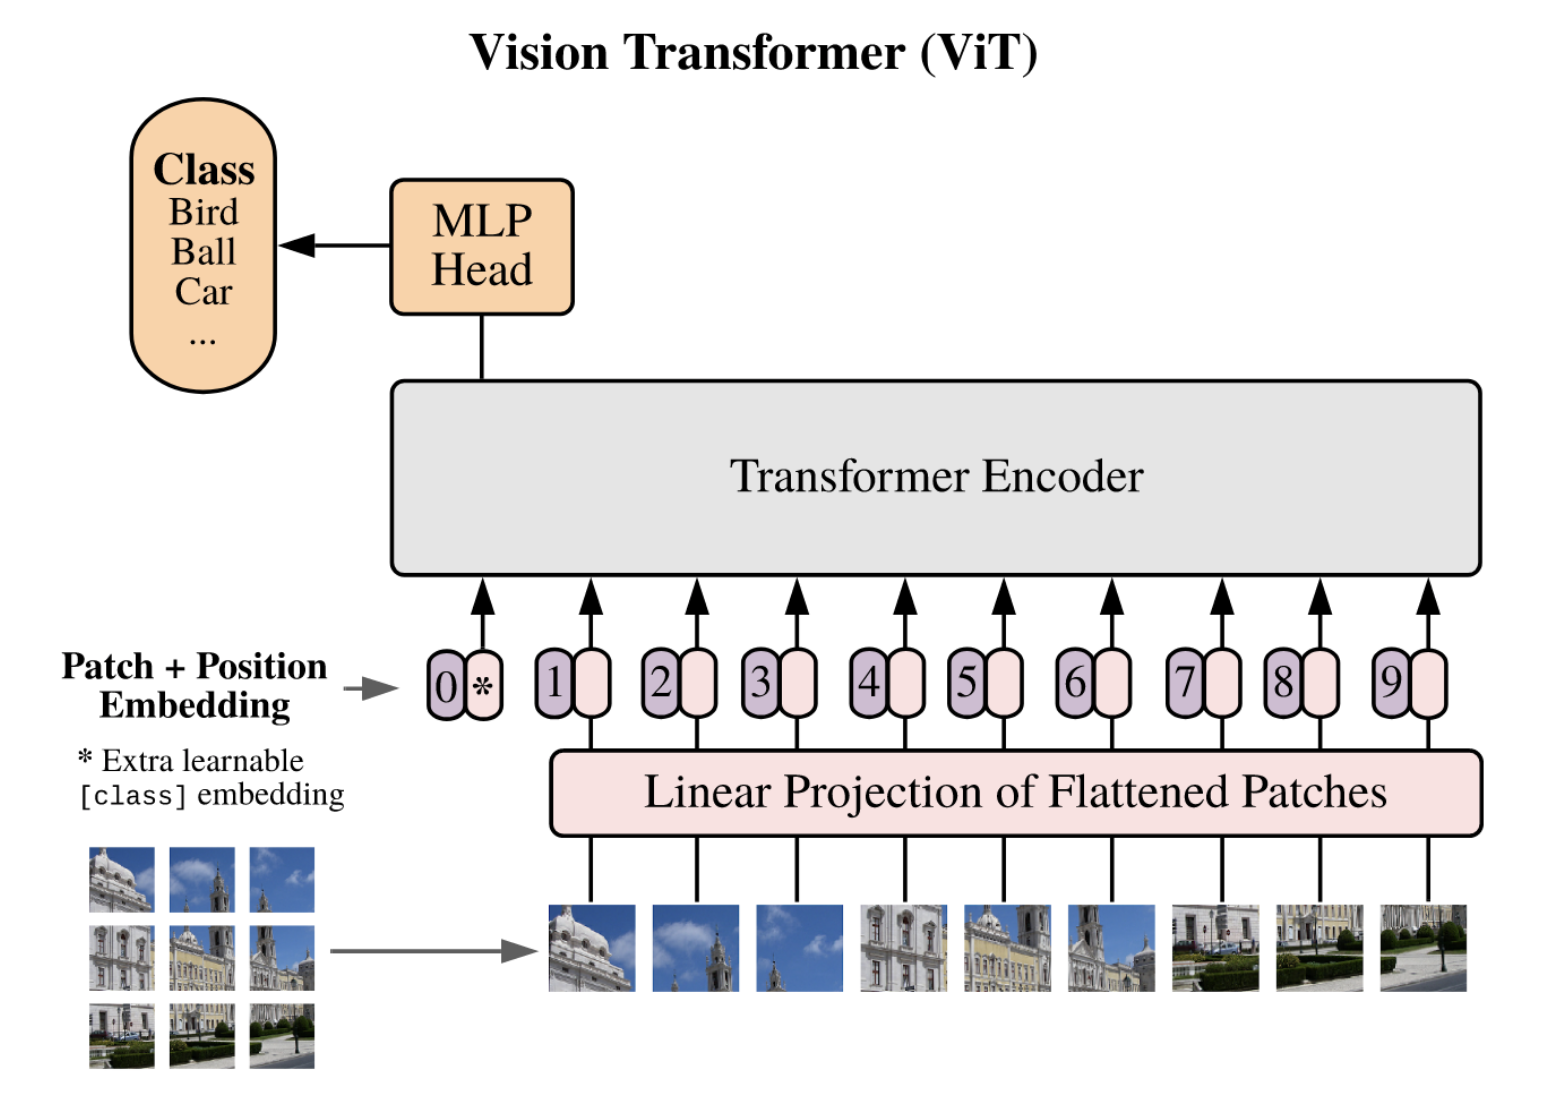

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
        super().__init__()
        # Conv2d with kernel size and stride equal to patch_size
        self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x is of shape (B, C, H, W)
        x = self.projection(x)  # (B, embed_dim, H', W')

        # Reshaping to (B, embed_dim, H'*W')
        B, C, H, W = x.shape
        x = x.view(B, C, H * W)

        # Transpose to get (B, H'*W', embed_dim)
        x = x.permute(0, 2, 1)

        # Output shape: (batch_size, nb_patches, embedding_dim)
        return x

In [ ]:
# Test with a random input
batch_size = 2
in_chan = 1
img_size = 28
patch_size = 7
embed_dim = 128

x = torch.randn(batch_size, in_chan, img_size, img_size)
model = PatchEmbed(in_chan, patch_size, embed_dim)
output = model(x)

print(output.shape)  # Should be (batch_size, nb_patches, embed_dim)

torch.Size([2, 16, 128])


# Transformer encoder

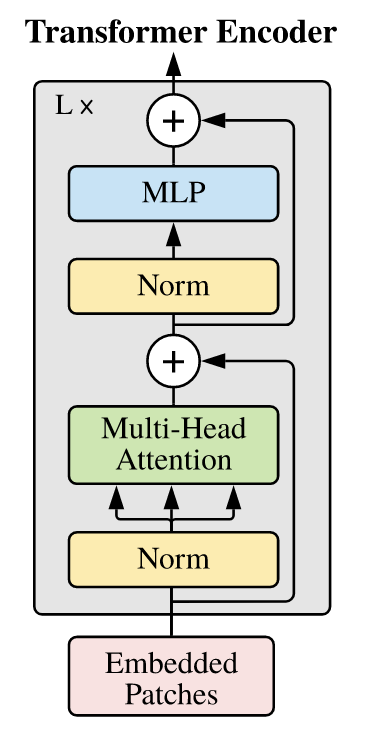

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_features, hid_features):
        super().__init__()
        # Define the two linear layers
        self.fc1 = nn.Linear(in_features, hid_features)  # First layer: input to hidden
        self.gelu = nn.GELU()                           # GELU activation function
        self.fc2 = nn.Linear(hid_features, in_features) # Second layer: hidden to output

    def forward(self, x):
        # First linear layer, followed by GELU activation
        x = self.fc1(x)
        x = self.gelu(x)
        # Second linear layer (output layer)
        x = self.fc2(x)
        return x

# Test the MLP with input shape (32, 16, 128)
mlp = MLP(128, 512)
output = mlp(torch.randn(32, 16, 128))

print(output.shape)  # Should be (32, 16, 128)

torch.Size([32, 16, 128])


## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        # Linear projections for Q, K, and V
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        # Final linear projection after attention
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape  # B = batch size, N = number of tokens, C = embedding dimension

        # Compute Q, K, V
        q = self.q_proj(x)  # (B, N, C)
        k = self.k_proj(x)  # (B, N, C)
        v = self.v_proj(x)  # (B, N, C)

        # Compute attention scores: Q * K^T / sqrt(d_k)
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (C ** 0.5)  # (B, N, N)

        # Apply softmax to get the attention weights
        attention = F.softmax(attn_scores, dim=-1)  # (B, N, N)

        # Use attention weights to compute a weighted sum of the values
        attended_values = torch.matmul(attention, v)  # (B, N, C)

        # Apply the final projection
        x = self.out_proj(attended_values)  # (B, N, C)

        return x

# Test the SelfAttention with input shape (32, 16, 128)
self_attention = SelfAttention(128)
output = self_attention(torch.randn(32, 16, 128))

print(output.shape)  # Should be (32, 16, 128)

torch.Size([32, 16, 128])


# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadsSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads  # Dimension of each head
        self.scale = self.head_dim ** -0.5  # Scaling factor

        # Linear layers to project input into queries, keys, values for all heads
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        # Final linear layer to combine heads' outputs
        self.projection = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape  # B = batch size, N = number of tokens, C = embedding dimension

        # Compute Q, K, V projections
        q = self.q_proj(x)  # Shape: (B, N, C)
        k = self.k_proj(x)  # Shape: (B, N, C)
        v = self.v_proj(x)  # Shape: (B, N, C)

        # Reshape to split into multiple heads and permute dimensions
        # Shape before: (B, N, C), after: (B, num_heads, N, head_dim)
        q = q.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, num_heads, N, head_dim)
        k = k.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, num_heads, N, head_dim)
        v = v.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # (B, num_heads, N, head_dim)

        # Compute attention scores for each head
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # Shape: (B, num_heads, N, N)
        attention = F.softmax(attn_scores, dim=-1)  # Apply softmax over the last dimension

        # Compute attention output by multiplying with values
        attn_output = torch.matmul(attention, v)  # Shape: (B, num_heads, N, head_dim)

        # Concatenate the heads' output (back to B, N, C)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()  # (B, N, num_heads, head_dim)
        attn_output = attn_output.view(B, N, C)  # (B, N, C)

        # Final linear projection
        x = self.projection(attn_output)  # Shape: (B, N, C)

        return x

# Test the MultiHeadsSelfAttention with input shape (32, 16, 128) and 4 heads
multihead_attention = MultiHeadsSelfAttention(128, 4)
output = multihead_attention(torch.randn(32, 16, 128))

print(output.shape)  # Should be (32, 16, 128)


torch.Size([32, 16, 128])


# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

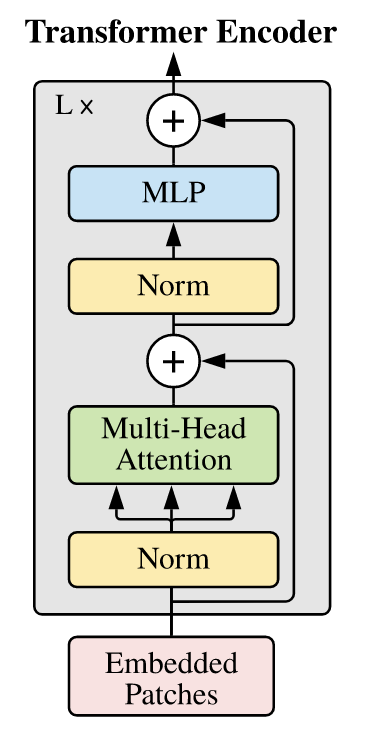

- The Transformer Block described in the image consists of several key components:

- Multi-Head Attention: Computes the attention across different heads.
Layer Normalization: Applied before and after the attention and MLP blocks.
MLP: A fully connected feed-forward network with a hidden layer.
Residual Connections: Shortcut connections that add the input to the output of the attention and MLP layers.

- Equations:

Multi-Head Attention:

Attention(𝑋)=MultiHeadSelfAttention(LayerNorm(𝑋))+𝑋

This equation means that we apply layer normalization on 𝑋 before passing it to the multi-head attention. Then, we add the original input 𝑋 to the output of the attention (residual connection).

- MLP:

MLP(𝑋)=FeedForward(LayerNorm(𝑋))+𝑋

Similar to attention, layer normalization is applied first, followed by an MLP block, and then a residual connection adds the input back.

In [ ]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
        super().__init__()
        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Multi-Head Attention
        self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)

        # MLP block: two fully connected layers with GELU activation
        hidden_dim = embed_dim * mlp_ratio
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embed_dim),
        )

    def forward(self, x):
        # Multi-Head Attention with residual connection
        attn_out = self.attention(self.norm1(x)) + x

        # MLP with residual connection
        mlp_out = self.mlp(self.norm2(attn_out)) + attn_out

        return mlp_out

# Test the transformer block with input shape (32, 16, 128)
block = Block(128, num_heads=4)
output = block(torch.randn(32, 16, 128))

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\
- Explain whay is the the positional embedding (PE) and why it is important? \\

For PE, you can use a sinusoidal encoding (see below), or fully learned.


### Sinusoidal PE


In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(get_positional_embeddings(num_patches + 1, embed_dim).to(torch.float32))
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, nb_classes)

  def forward(self, x):
    # Convert image to patches
      x = self.patch_embed(x)  # (B, num_patches, embed_dim)

      # Concatenating class token
      class_token = self.class_token.expand(x.size(0), -1, -1)  # (B, 1, embed_dim)
      x = torch.cat((class_token, x), dim=1)  # (B, 1 + num_patches, embed_dim)

      # Adding positional embedding
      x = x + self.pos_embed  # (B, 1 + num_patches, embed_dim)

      # Forward in the transformer blocks
      x = self.blocks(x)

      # Normalize the output
      x = self.norm(x)

      # Classification head on the class token
      output = self.head(x[:, 0])  # (B, embed_dim) -> (B, nb_classes)

      return output


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

In [ ]:
model = ViT(128, 3, 7)
output = model(torch.randn(32, 1, 28, 28))
print(output.shape)  # Expected output: (32, 10)

torch.Size([32, 10])


# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [ ]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

train_losses=[]
train_acc=[]
test_acc=[]

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = (
        x.cuda(),
        y.cuda()
    )

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
  acc = eval_model(model, train_loader)
  print(f"Train accuracy: {acc}")
  train_losses.append(train_loss / len(train_loader))
  train_acc.append(acc)
  acc = eval_model(model, test_loader)
  print(f"Test accuracy: {acc}")
  test_acc.append(acc)


--- Epoch 0 ---
Train loss: 0.742742159918173
Train accuracy: 91.89
Test accuracy: 92.45
--- Epoch 1 ---
Train loss: 0.22451172416398266
Train accuracy: 94.22
Test accuracy: 94.16
--- Epoch 2 ---
Train loss: 0.16002942554191993
Train accuracy: 95.24
Test accuracy: 95.21
--- Epoch 3 ---
Train loss: 0.13090545887441268
Train accuracy: 96.61
Test accuracy: 96.18
--- Epoch 4 ---
Train loss: 0.11519042176526112
Train accuracy: 96.94
Test accuracy: 96.14
--- Epoch 5 ---
Train loss: 0.0970993004401705
Train accuracy: 97.31
Test accuracy: 96.73
--- Epoch 6 ---
Train loss: 0.08785722205347853
Train accuracy: 97.76
Test accuracy: 97.09
--- Epoch 7 ---
Train loss: 0.07996362504531453
Train accuracy: 97.81
Test accuracy: 97.13
--- Epoch 8 ---
Train loss: 0.07391646990516801
Train accuracy: 97.85
Test accuracy: 96.88
--- Epoch 9 ---
Train loss: 0.06725472488156609
Train accuracy: 98.4
Test accuracy: 97.32


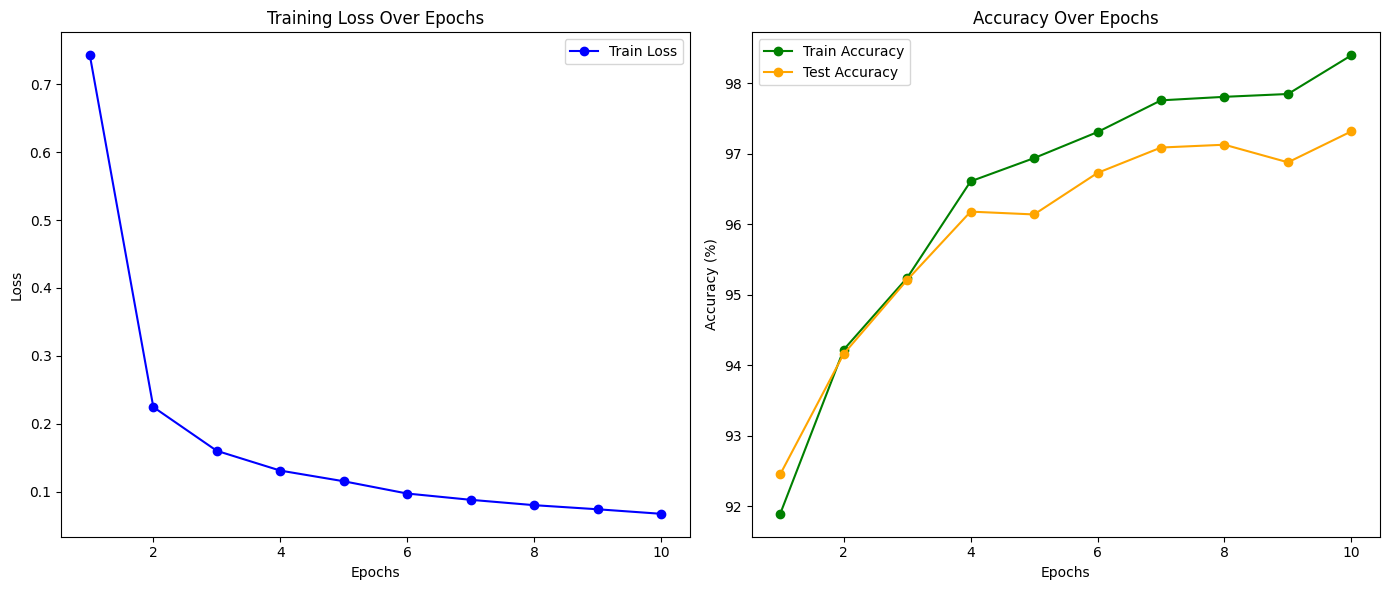

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(train_losses, train_acc, test_acc, epochs):
    epochs_range = range(1, epochs + 1)

    # Create a figure with 2 subplots: one for loss, one for accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training loss
    ax1.plot(epochs_range, train_losses, label='Train Loss', color='blue', marker='o')
    ax1.set_title('Training Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs_range, train_acc, label='Train Accuracy', color='green', marker='o')
    ax2.plot(epochs_range, test_acc, label='Test Accuracy', color='orange', marker='o')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Example usage with data from training run
plot_training_results(train_losses, train_acc, test_acc, epochs=epochs)


# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import tqdm

# Assuming train_loader and test_loader are already defined

def run_experiment(embed_dim, patch_size, nb_blocks, epochs=10):
    model = ViT(embed_dim, nb_blocks, patch_size).cuda()
    opt = torch.optim.Adam(model.parameters())

    train_losses = []
    train_acc = []
    test_acc = []

    for epoch in tqdm.tqdm(list(range(epochs))):
        train_loss = 0.
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            opt.zero_grad()
            yhat = model(x)
            loss = F.cross_entropy(yhat, y)
            loss.backward()

            opt.step()

            train_loss += loss.item()

        # print(f"--- Epoch {epoch} ---")
        # print(f"Train loss: {train_loss / len(train_loader)}")
        acc = eval_model(model, train_loader)
        # print(f"Train accuracy: {acc}")
        train_losses.append(train_loss / len(train_loader))
        train_acc.append(acc)
        acc = eval_model(model, test_loader)
        # print(f"Test accuracy: {acc}")
        test_acc.append(acc)

    return train_losses, train_acc, test_acc

# Example: Testing different configurations
embed_dims = [8, 16, 32,]  # Different embedding dimensions
patch_sizes = [7, 14]  # Different patch sizes
nb_blocks_list = [1, 2, 4]  # Different numbers of transformer blocks

# results = {}
# hyperparameter_configs = []

for embed_dim in embed_dims:
    for patch_size in patch_sizes:
        for nb_blocks in nb_blocks_list:
            config = (embed_dim, patch_size, nb_blocks)
            hyperparameter_configs.append(config)
            print(f"Testing embed_dim={embed_dim}, patch_size={patch_size}, nb_blocks={nb_blocks}")
            train_losses, train_acc, test_acc = run_experiment(embed_dim, patch_size, nb_blocks)
            results[config] = (train_losses, train_acc, test_acc)



Testing embed_dim=8, patch_size=7, nb_blocks=1


100%|██████████| 10/10 [02:38<00:00, 15.83s/it]


Testing embed_dim=8, patch_size=7, nb_blocks=2


100%|██████████| 10/10 [02:50<00:00, 17.00s/it]


Testing embed_dim=8, patch_size=7, nb_blocks=4


100%|██████████| 10/10 [03:15<00:00, 19.59s/it]


Testing embed_dim=8, patch_size=14, nb_blocks=1


100%|██████████| 10/10 [02:37<00:00, 15.71s/it]


Testing embed_dim=8, patch_size=14, nb_blocks=2


100%|██████████| 10/10 [02:51<00:00, 17.14s/it]


Testing embed_dim=8, patch_size=14, nb_blocks=4


100%|██████████| 10/10 [03:18<00:00, 19.83s/it]


Testing embed_dim=16, patch_size=7, nb_blocks=1


100%|██████████| 10/10 [02:37<00:00, 15.75s/it]


Testing embed_dim=16, patch_size=7, nb_blocks=2


100%|██████████| 10/10 [02:50<00:00, 17.05s/it]


Testing embed_dim=16, patch_size=7, nb_blocks=4


100%|██████████| 10/10 [03:17<00:00, 19.77s/it]


Testing embed_dim=16, patch_size=14, nb_blocks=1


100%|██████████| 10/10 [02:36<00:00, 15.67s/it]


Testing embed_dim=16, patch_size=14, nb_blocks=2


100%|██████████| 10/10 [02:50<00:00, 17.00s/it]


Testing embed_dim=16, patch_size=14, nb_blocks=4


100%|██████████| 10/10 [03:16<00:00, 19.69s/it]


Testing embed_dim=32, patch_size=7, nb_blocks=1


100%|██████████| 10/10 [02:35<00:00, 15.58s/it]


Testing embed_dim=32, patch_size=7, nb_blocks=2


100%|██████████| 10/10 [02:49<00:00, 17.00s/it]


Testing embed_dim=32, patch_size=7, nb_blocks=4


100%|██████████| 10/10 [03:17<00:00, 19.71s/it]


Testing embed_dim=32, patch_size=14, nb_blocks=1


100%|██████████| 10/10 [02:35<00:00, 15.59s/it]


Testing embed_dim=32, patch_size=14, nb_blocks=2


100%|██████████| 10/10 [02:49<00:00, 16.97s/it]


Testing embed_dim=32, patch_size=14, nb_blocks=4


100%|██████████| 10/10 [03:17<00:00, 19.73s/it]


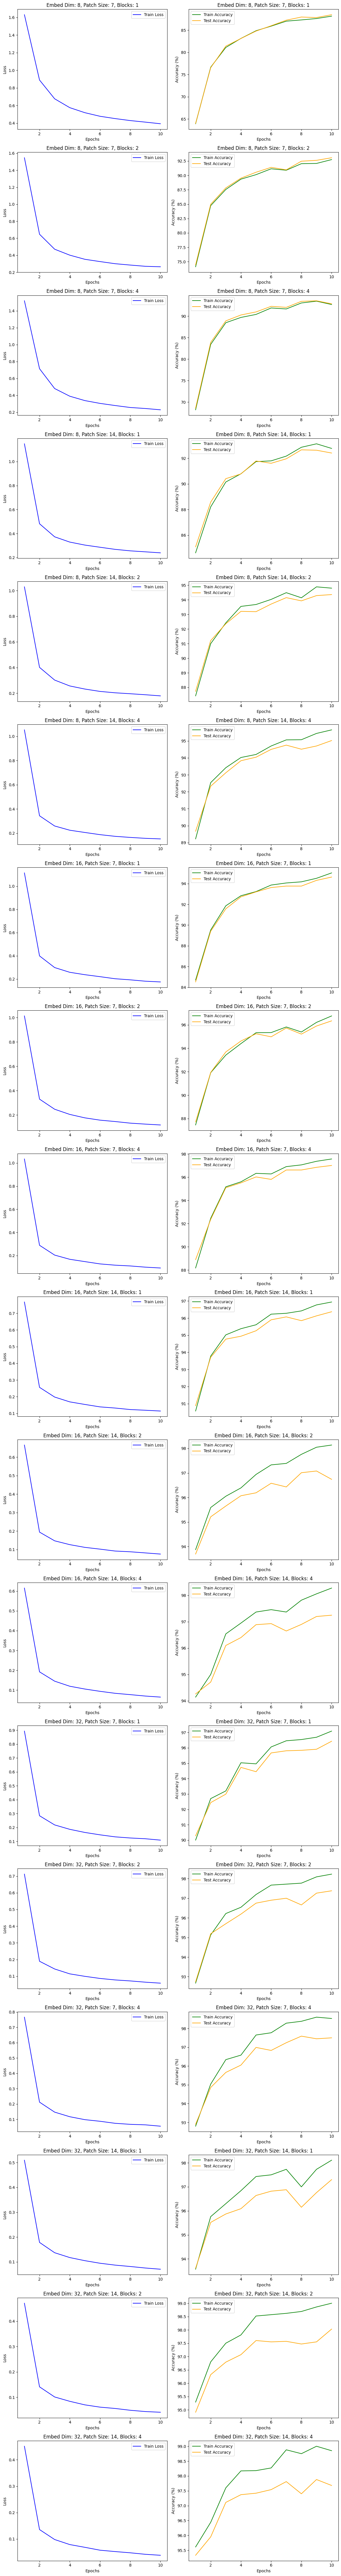

In [ ]:
# Now plot all the results
def plot_results(hyperparameter_configs, results):
    num_configs = len(hyperparameter_configs)
    epochs = range(1, len(results[hyperparameter_configs[0]][0]) + 1)

    fig, axes = plt.subplots(num_configs, 2, figsize=(12, 5 * num_configs))

    for idx, (config, res) in enumerate(zip(hyperparameter_configs, results.values())):
        embed_dim, patch_size, nb_blocks = config
        train_losses, train_acc, test_acc = res

        # Plot training loss
        axes[idx, 0].plot(epochs, train_losses, label='Train Loss', color='blue')
        axes[idx, 0].set_title(f'Embed Dim: {embed_dim}, Patch Size: {patch_size}, Blocks: {nb_blocks}')
        axes[idx, 0].set_xlabel('Epochs')
        axes[idx, 0].set_ylabel('Loss')
        axes[idx, 0].legend()

        # Plot accuracy
        axes[idx, 1].plot(epochs, train_acc, label='Train Accuracy', color='green')
        axes[idx, 1].plot(epochs, test_acc, label='Test Accuracy', color='orange')
        axes[idx, 1].set_title(f'Embed Dim: {embed_dim}, Patch Size: {patch_size}, Blocks: {nb_blocks}')
        axes[idx, 1].set_xlabel('Epochs')
        axes[idx, 1].set_ylabel('Accuracy (%)')
        axes[idx, 1].legend()

    plt.tight_layout()
    plt.show()

plot_results(hyperparameter_configs, results)

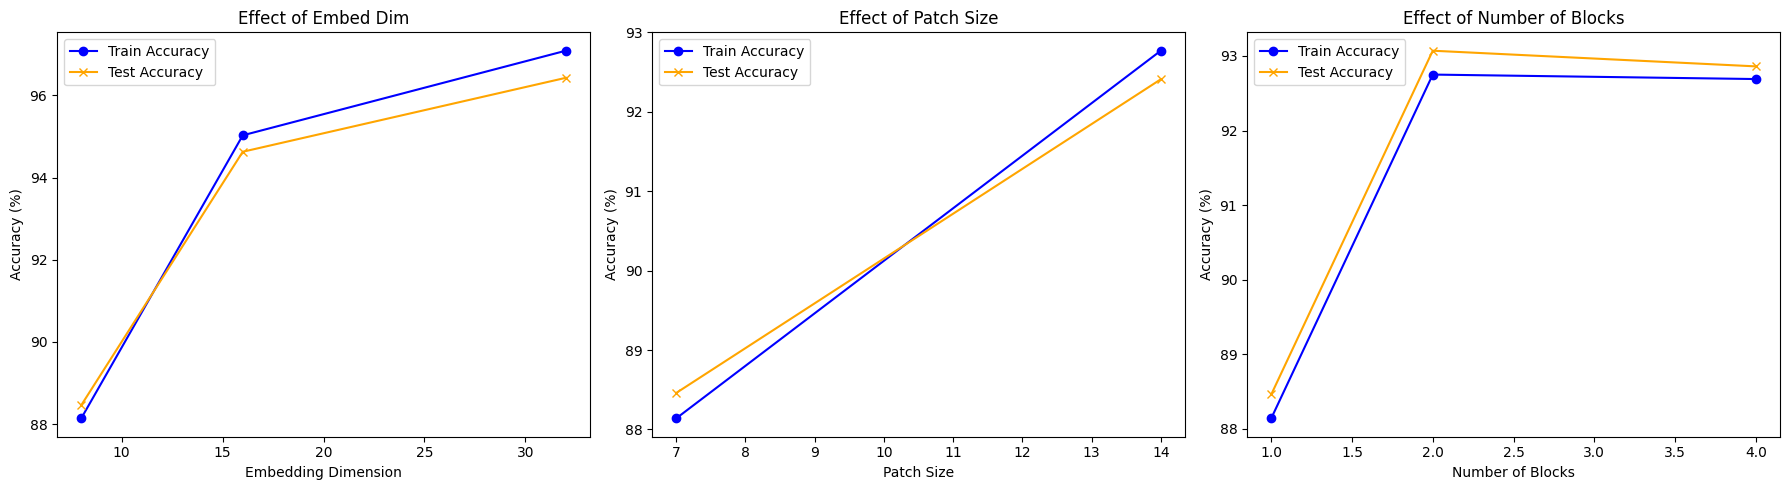

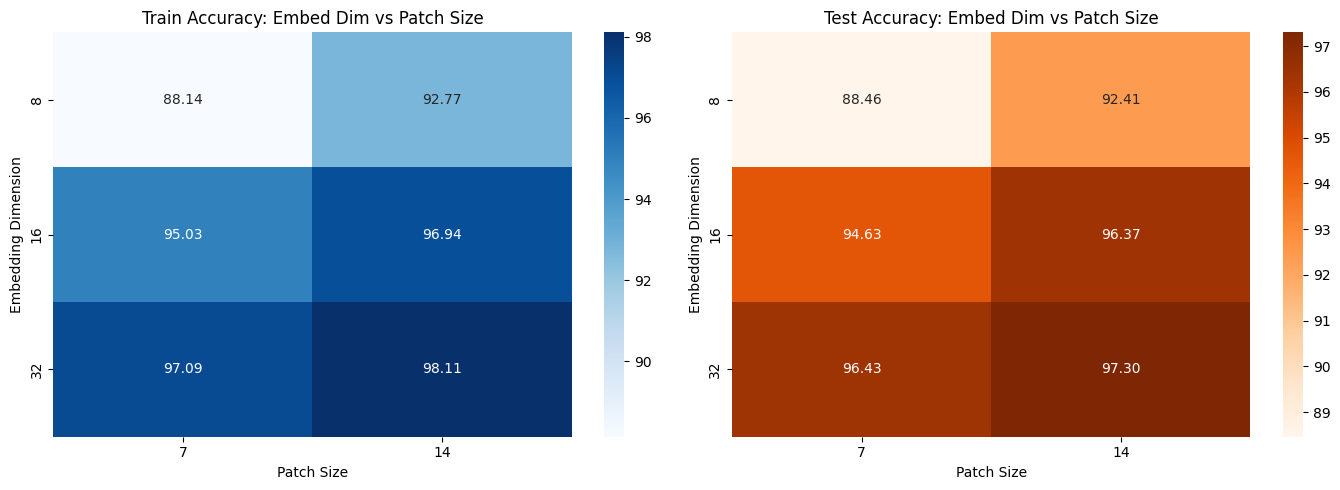

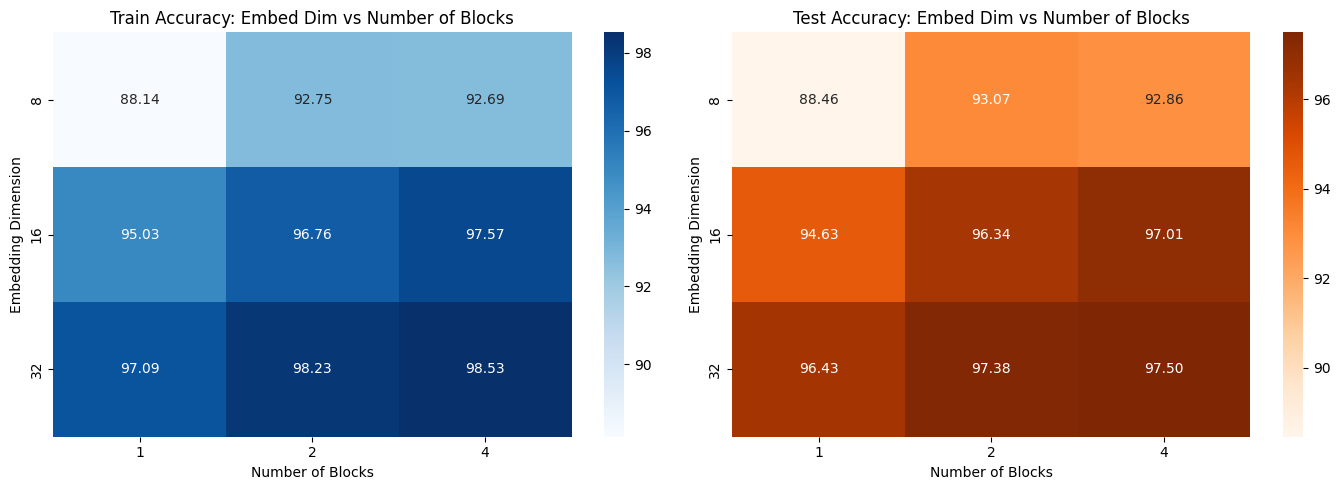

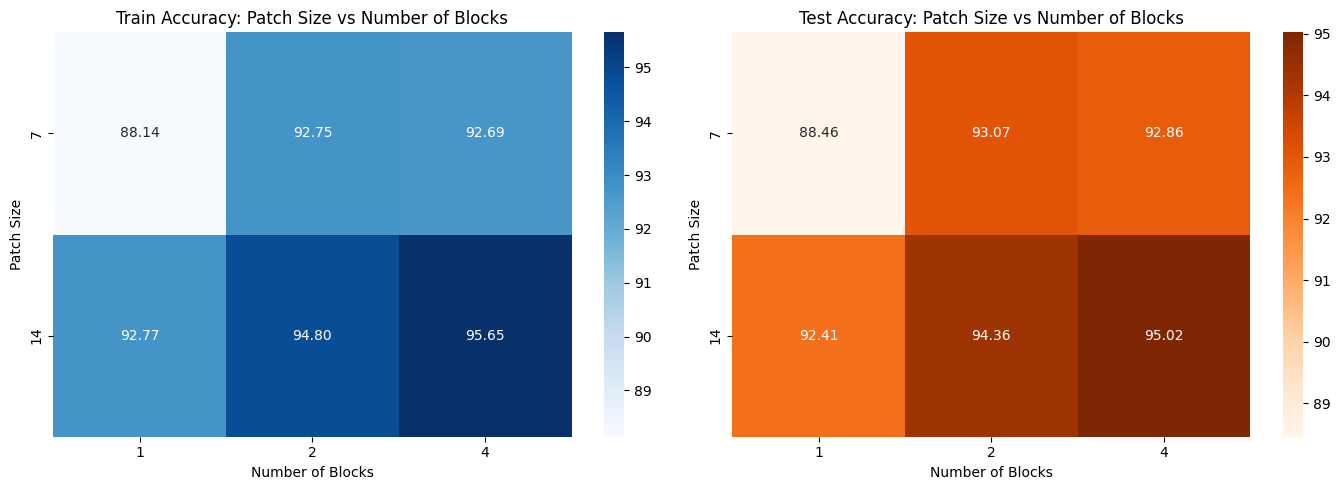

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_hyperparameters(results):
    # Extract unique values for each hyperparameter
    embed_dims = sorted({config[0] for config in results.keys()})
    patch_sizes = sorted({config[1] for config in results.keys()})
    nb_blocks_list = sorted({config[2] for config in results.keys()})

    # Prepare data structures to store final accuracies
    final_train_acc = {}
    final_test_acc = {}

    # Collect final accuracy results for each configuration
    for (embed_dim, patch_size, nb_blocks), (_, train_acc, test_acc) in results.items():
        key = (embed_dim, patch_size, nb_blocks)
        final_train_acc[key] = train_acc[-1]
        final_test_acc[key] = test_acc[-1]

    # Plotting the effect of each hyperparameter individually
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot for Embed Dim
    embed_train_acc = [final_train_acc[(embed_dim, patch_sizes[0], nb_blocks_list[0])] for embed_dim in embed_dims]
    embed_test_acc = [final_test_acc[(embed_dim, patch_sizes[0], nb_blocks_list[0])] for embed_dim in embed_dims]
    axes[0].plot(embed_dims, embed_train_acc, label="Train Accuracy", marker='o', color='blue')
    axes[0].plot(embed_dims, embed_test_acc, label="Test Accuracy", marker='x', color='orange')
    axes[0].set_title("Effect of Embed Dim")
    axes[0].set_xlabel("Embedding Dimension")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].legend()

    # Plot for Patch Size
    patch_train_acc = [final_train_acc[(embed_dims[0], patch_size, nb_blocks_list[0])] for patch_size in patch_sizes]
    patch_test_acc = [final_test_acc[(embed_dims[0], patch_size, nb_blocks_list[0])] for patch_size in patch_sizes]
    axes[1].plot(patch_sizes, patch_train_acc, label="Train Accuracy", marker='o', color='blue')
    axes[1].plot(patch_sizes, patch_test_acc, label="Test Accuracy", marker='x', color='orange')
    axes[1].set_title("Effect of Patch Size")
    axes[1].set_xlabel("Patch Size")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].legend()

    # Plot for Number of Blocks
    block_train_acc = [final_train_acc[(embed_dims[0], patch_sizes[0], nb_blocks)] for nb_blocks in nb_blocks_list]
    block_test_acc = [final_test_acc[(embed_dims[0], patch_sizes[0], nb_blocks)] for nb_blocks in nb_blocks_list]
    axes[2].plot(nb_blocks_list, block_train_acc, label="Train Accuracy", marker='o', color='blue')
    axes[2].plot(nb_blocks_list, block_test_acc, label="Test Accuracy", marker='x', color='orange')
    axes[2].set_title("Effect of Number of Blocks")
    axes[2].set_xlabel("Number of Blocks")
    axes[2].set_ylabel("Accuracy (%)")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Extract unique values for each hyperparameter
    embed_dims = sorted({config[0] for config in results.keys()})
    patch_sizes = sorted({config[1] for config in results.keys()})
    nb_blocks_list = sorted({config[2] for config in results.keys()})

    # Prepare data structures to store final accuracies
    final_train_acc = {}
    final_test_acc = {}

    # Collect final accuracy results for each configuration
    for (embed_dim, patch_size, nb_blocks), (_, train_acc, test_acc) in results.items():
        key = (embed_dim, patch_size, nb_blocks)
        final_train_acc[key] = train_acc[-1]
        final_test_acc[key] = test_acc[-1]

    # Heatmap for Embed Dim vs Patch Size (keeping nb_blocks constant)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    embed_patch_train = np.array([[final_train_acc[(embed_dim, patch_size, nb_blocks_list[0])]
                                   for patch_size in patch_sizes] for embed_dim in embed_dims])
    embed_patch_test = np.array([[final_test_acc[(embed_dim, patch_size, nb_blocks_list[0])]
                                  for patch_size in patch_sizes] for embed_dim in embed_dims])
    sns.heatmap(embed_patch_train, annot=True, fmt=".2f", xticklabels=patch_sizes, yticklabels=embed_dims, ax=ax[0], cmap="Blues")
    ax[0].set_title("Train Accuracy: Embed Dim vs Patch Size")
    ax[0].set_xlabel("Patch Size")
    ax[0].set_ylabel("Embedding Dimension")
    sns.heatmap(embed_patch_test, annot=True, fmt=".2f", xticklabels=patch_sizes, yticklabels=embed_dims, ax=ax[1], cmap="Oranges")
    ax[1].set_title("Test Accuracy: Embed Dim vs Patch Size")
    ax[1].set_xlabel("Patch Size")
    ax[1].set_ylabel("Embedding Dimension")
    plt.tight_layout()
    plt.show()

    # Heatmap for Embed Dim vs Number of Blocks (keeping patch_size constant)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    embed_block_train = np.array([[final_train_acc[(embed_dim, patch_sizes[0], nb_blocks)]
                                   for nb_blocks in nb_blocks_list] for embed_dim in embed_dims])
    embed_block_test = np.array([[final_test_acc[(embed_dim, patch_sizes[0], nb_blocks)]
                                  for nb_blocks in nb_blocks_list] for embed_dim in embed_dims])
    sns.heatmap(embed_block_train, annot=True, fmt=".2f", xticklabels=nb_blocks_list, yticklabels=embed_dims, ax=ax[0], cmap="Blues")
    ax[0].set_title("Train Accuracy: Embed Dim vs Number of Blocks")
    ax[0].set_xlabel("Number of Blocks")
    ax[0].set_ylabel("Embedding Dimension")
    sns.heatmap(embed_block_test, annot=True, fmt=".2f", xticklabels=nb_blocks_list, yticklabels=embed_dims, ax=ax[1], cmap="Oranges")
    ax[1].set_title("Test Accuracy: Embed Dim vs Number of Blocks")
    ax[1].set_xlabel("Number of Blocks")
    ax[1].set_ylabel("Embedding Dimension")
    plt.tight_layout()
    plt.show()

    # Heatmap for Patch Size vs Number of Blocks (keeping embed_dim constant)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    patch_block_train = np.array([[final_train_acc[(embed_dims[0], patch_size, nb_blocks)]
                                   for nb_blocks in nb_blocks_list] for patch_size in patch_sizes])
    patch_block_test = np.array([[final_test_acc[(embed_dims[0], patch_size, nb_blocks)]
                                  for nb_blocks in nb_blocks_list] for patch_size in patch_sizes])
    sns.heatmap(patch_block_train, annot=True, fmt=".2f", xticklabels=nb_blocks_list, yticklabels=patch_sizes, ax=ax[0], cmap="Blues")
    ax[0].set_title("Train Accuracy: Patch Size vs Number of Blocks")
    ax[0].set_xlabel("Number of Blocks")
    ax[0].set_ylabel("Patch Size")
    sns.heatmap(patch_block_test, annot=True, fmt=".2f", xticklabels=nb_blocks_list, yticklabels=patch_sizes, ax=ax[1], cmap="Oranges")
    ax[1].set_title("Test Accuracy: Patch Size vs Number of Blocks")
    ax[1].set_xlabel("Number of Blocks")
    ax[1].set_ylabel("Patch Size")
    plt.tight_layout()
    plt.show()


analyze_hyperparameters(results)

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [ ]:
! pip install timm

a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [ ]:
import timm
model = timm.create_model('vit_small_patch16_224', pretrained=False)

In [ ]:
x = torch.randn(32, 1, 28, 28)
x = x.repeat(1, 3, 1, 1)  # Convert grayscale (1 channel) to RGB (3 channels)
model(x).shape

AssertionError: Input height (28) doesn't match model (224).

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [ ]:
model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=10, img_size=28)

model(torch.randn(32, 3, 28, 28)).shape

torch.Size([32, 10])

c) redo the training with the ViT-S





In [ ]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    x = x.repeat(1, num_channels, 1, 1) # adapt number of channels to fit in ViT

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [ ]:
import timm

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

train_losses_nprt=[]
train_acc_nprt=[]
test_acc_nprt=[]

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")

  print(f"Train loss: {train_loss / len(train_loader)}")
  train_losses_nprt.append(train_loss / len(train_loader))

  acc = eval_model(model, train_loader, num_channels=3)
  print(f"Train accuracy: {acc}")
  train_acc_nprt.append(acc)

  acc = eval_model(model, test_loader, num_channels=3)
  print(f"Test accuracy: {acc}")
  test_acc_nprt.append(acc)


--- Epoch 0 ---
Train loss: 0.8143581685099774
Train accuracy: 82.09
Test accuracy: 82.24
--- Epoch 1 ---
Train loss: 0.530652368818519
Train accuracy: 84.73
Test accuracy: 85.14
--- Epoch 2 ---
Train loss: 0.4706166167376138
Train accuracy: 85.94
Test accuracy: 86.21
--- Epoch 3 ---
Train loss: 0.44004587784631927
Train accuracy: 86.82
Test accuracy: 86.69
--- Epoch 4 ---
Train loss: 0.4132855919950298
Train accuracy: 85.39
Test accuracy: 85.08
--- Epoch 5 ---
Train loss: 0.4021427056936821
Train accuracy: 87.25
Test accuracy: 86.82
--- Epoch 6 ---
Train loss: 0.3910753889950608
Train accuracy: 87.23
Test accuracy: 86.99
--- Epoch 7 ---
Train loss: 0.3789297137687455
Train accuracy: 87.18
Test accuracy: 86.83
--- Epoch 8 ---
Train loss: 0.3695399098749608
Train accuracy: 88.58
Test accuracy: 87.64
--- Epoch 9 ---
Train loss: 0.35665222563977433
Train accuracy: 88.47
Test accuracy: 87.63


c) redo the training but with the ViT-S pretrained on ImageNet

In [ ]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=10, img_size=28)

In [ ]:
import timm

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

train_losses_prt=[]
train_acc_prt=[]
test_acc_prt=[]

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = x.repeat(1, 3, 1, 1) # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")

  print(f"Train loss: {train_loss / len(train_loader)}")
  train_losses_prt.append(train_loss / len(train_loader))

  acc = eval_model(model, train_loader, num_channels=3)
  print(f"Train accuracy: {acc}")
  train_acc_prt.append(acc)

  acc = eval_model(model, test_loader, num_channels=3)
  print(f"Test accuracy: {acc}")
  test_acc_prt.append(acc)



--- Epoch 0 ---
Train loss: 0.6466666133101306
Train accuracy: 88.01
Test accuracy: 87.79
--- Epoch 1 ---
Train loss: 0.33861007080721195
Train accuracy: 91.26
Test accuracy: 90.45
--- Epoch 2 ---
Train loss: 0.2945351788738389
Train accuracy: 91.58
Test accuracy: 90.51
--- Epoch 3 ---
Train loss: 0.2658368169403534
Train accuracy: 91.04
Test accuracy: 89.17
--- Epoch 4 ---
Train loss: 0.248575961586636
Train accuracy: 92.83
Test accuracy: 90.79
--- Epoch 5 ---
Train loss: 0.23151375010196587
Train accuracy: 93.56
Test accuracy: 91.23
--- Epoch 6 ---
Train loss: 0.21324510818351305
Train accuracy: 94.01
Test accuracy: 91.38
--- Epoch 7 ---
Train loss: 0.20369116407531157
Train accuracy: 94.51
Test accuracy: 91.56
--- Epoch 8 ---
Train loss: 0.19555697597261432
Train accuracy: 93.98
Test accuracy: 90.77
--- Epoch 9 ---
Train loss: 0.19082129499646647
Train accuracy: 94.88
Test accuracy: 91.52


d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.

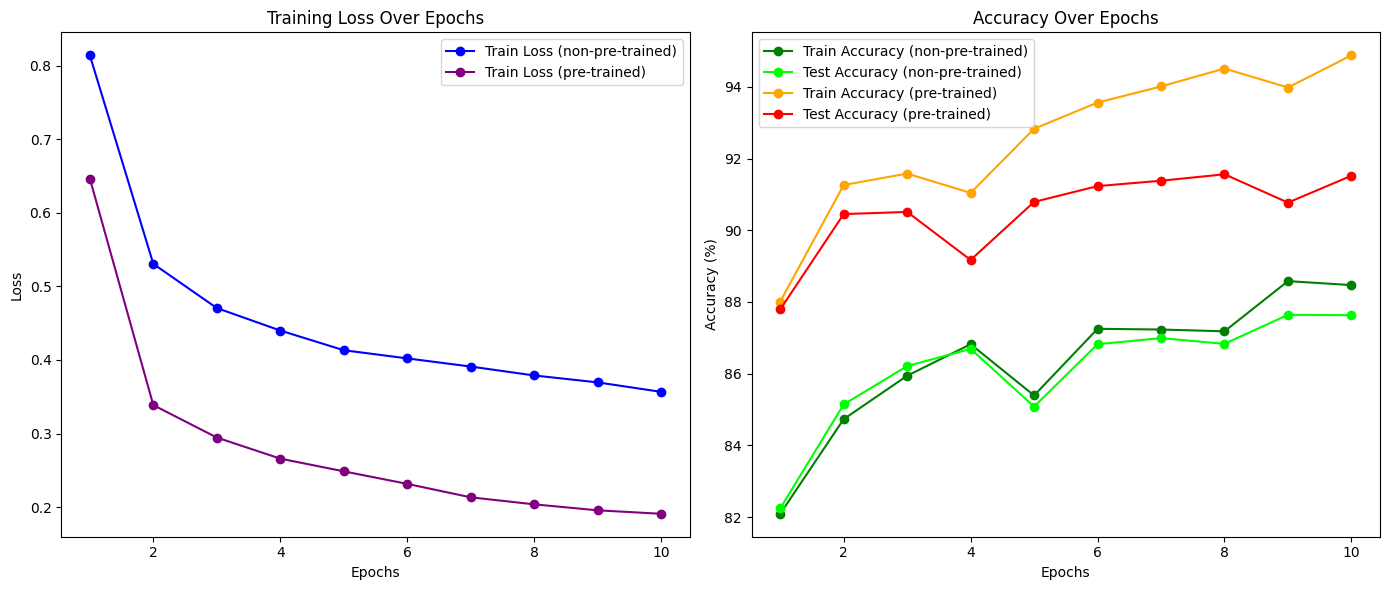

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(
    train_losses_prt, train_acc_prt, test_acc_prt,
    train_losses_nprt, train_acc_nprt, test_acc_nprt,
    epochs
):
    epochs_range = range(1, epochs + 1)

    # Create a figure with 2 subplots: one for loss, one for accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training loss
    ax1.plot(epochs_range, train_losses_nprt, label='Train Loss (non-pre-trained)', color='blue', marker='o')
    ax1.plot(epochs_range, train_losses_prt, label='Train Loss (pre-trained)', color='purple', marker='o')
    ax1.set_title('Training Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs_range, train_acc_nprt, label='Train Accuracy (non-pre-trained)', color='green', marker='o')
    ax2.plot(epochs_range, test_acc_nprt, label='Test Accuracy (non-pre-trained)', color='lime', marker='o')
    # Plot accuracy
    ax2.plot(epochs_range, train_acc_prt, label='Train Accuracy (pre-trained)', color='orange', marker='o')
    ax2.plot(epochs_range, test_acc_prt, label='Test Accuracy (pre-trained)', color='red', marker='o')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Example usage with data from training run
plot_training_results(train_losses_prt, train_acc_prt, test_acc_prt, train_losses_nprt, train_acc_nprt, test_acc_nprt, epochs=epochs)
